# 《绝地求生》玩家排名预测
                   ---- 你能预测《绝地求生》玩家战斗结束后的排名吗？


## 问题分析
这个数据集是一个回归问题；

结合目前学到的机器学习算法：

有监督
    - KNN
    - 决策树
    - 随机森林
    - 这三个算法既可以用来解决分类问题，也可以用来解决回归问题

无监督
    - Kmeans
    - PCA

集成学习：并不是某一个特定的算法，而是通过组合多个学习器打到提升预测效果的方法。
    - Bagging
    - Boosting
    - Stacking


## 导入数据

In [1]:
# 导入数据基本处理阶段需要用到的api
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# 导入数据
train = pd.read_csv("./data/train_V2.csv")
# 查看前10条数据；训练集数据需要特征+标签，在这里的标签是 `winplaceperc` 
# train.head()
# 查看有多少条记录
train.shape

(4446966, 29)

## 数据处理

In [4]:
# 数据处理
# 添加统计每场比赛的参赛人数字段 = playerJoined
# 显示每场比赛参加人数 matchId = 比赛ID
# transform的作用类似实现了一个一对多的映射功能，把统计数量映射到对应的每个样本上
# 原始样本中，没有参赛人数字段，所以我们通过聚合matchId统计到每场比赛的参赛人数
record_index_paylerJoined = train.groupby('matchId')['matchId'].transform('count')

# 输出两列，第一列是原始数据的index，第二列是这个index对应记录的的参赛人数
# print(record_index_paylerJoined)

# 放入原始数据中
train['playersJoined'] = record_index_paylerJoined

# 再次打印出原始数据中的数据：你会发现后面多了一列：playersJoined = 参赛人数
# train.head()

# 根据参赛人数排序：通过结果发现，最少的一局，竟然只有2个人。这种数据我们是不要的
# train["playersJoined"].sort_values().head()

# 通过绘制图像，查看每局开始人数：通过seaborn下的countplot方法，可以直接绘制统计过数量之后的直方图
# plt.figure(figsize=(20,10))
# sns.countplot(train['playersJoined'])
# plt.title('playersJoined')
# plt.grid()
# plt.show()

# 过滤掉参赛人数少于75人的记录，再次绘制每局参加人数的直方图
# plt.figure(figsize=(20,10))
# sns.countplot(train[train['playersJoined']>=75]['playersJoined'])
# plt.title('playersJoined')
# plt.grid()
# plt.show()

# 删除掉参赛人数少于75人的记录
matchId_to_drop_playersJoined = train[train['playersJoined']<75]['matchId']
train = train[~train['matchId'].isin(matchId_to_drop_playersJoined)]
train.shape

(4389644, 30)

In [5]:
# 数据处理
# 删除掉【标签winPlacePerc】不符合的数据：标签应该都是小于1的数字
# 将标签数据中不是数字的，改成NaN（errors='coerce'就是pandas提供的api，不符合的数据会被替换成NaN）
train['winPlacePerc'] = pd.to_numeric(train['winPlacePerc'], errors='coerce')
# 需要删除的标签非法的数据
matchId_to_drop_invalid_tag = train[(train['winPlacePerc'] > 1) | (train['winPlacePerc'].isna())]['matchId']
# 整场比赛的数据都不要了

# 删除有两种方式：一种是老师提供的，通过index删除
# train.drop(train[train['matchId'].isin(数据集)].index, inplace=True)

# 删除这些 matchId_record_to_drop 对应的所有记录
train = train[~train['matchId'].isin(matchId_to_drop_invalid_tag)]
train.shape


(4389644, 30)

In [6]:
# 数据处理
# 删除掉有 击杀，但是没有移动距离的记录（整场比赛的数据都不要了）
train['killsWithoutMoving'] = (train['kills'] > 0) & ((train['rideDistance'] + train['walkDistance'] + train['swimDistance']) == 0)
# train.head()
# 检查是否存在有击杀但是没有移动的数据
# train[train['killsWithoutMoving'] == True]
# 获取要删除的matchId 比赛ID
matchId_to_drop = train[train['killsWithoutMoving'] == True]['matchId']

# 删除前有 4446965 条记录. 删除后有 4417881 条记录

# 删除有两种方式：一种是老师提供的，通过index删除
# train.drop(train[train['matchId'].isin(matchId_to_drop)].index, inplace=True)

# 删除这些 matchId_record_to_drop 对应的所有记录
train = train[~train['matchId'].isin(matchId_to_drop)]
train.shape

(4368713, 31)

In [7]:
# 数据处理
# 删除掉爆头率异常的数据（击杀>10 && 爆头率=1）。 爆头率 = 爆头击杀数 / 总的击杀数
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)
# 从高到低排个序
# train["headshot_rate"].sort_values().tail()
# 绘制爆头率图像
# plt.figure(figsize=(12,4))
# sns.distplot(train['headshot_rate'], bins=10, kde=False)
# plt.show()
# 查看 爆头率=1 && 击杀数>10 的记录数
# train[(train['headshot_rate'] == 1) & (train['kills'] > 10)].shape
matchId_to_drop_headshot_rate = train[(train['headshot_rate'] == 1) & (train['kills'] > 10)]['matchId']

# 删除前有 4417881 条记录. 删除后有 4416640 条记录

# 删除这些 matchId_record_to_drop 对应的所有记录
train = train[~train['matchId'].isin(matchId_to_drop_headshot_rate)]
train.shape

(4367472, 32)

In [8]:
# 数据处理
# 删除最远杀敌距离 > 1000米 的异常数据

# 绘制杀敌记录的图像
# plt.figure(figsize=(12,4))
# sns.distplot(train['longestKill'], bins=10, kde=False)
# plt.show()

# 找出最远杀敌距离大于等于1km的玩家
# train[train['longestKill'] >= 1000].head()

matchId_to_drop_longestKill = train[train['longestKill'] >= 1000]['matchId']


# 删除
train = train[~train['matchId'].isin(matchId_to_drop_longestKill)]
train.shape

(4367291, 32)

In [9]:
# 数据处理
# 删除 walkDistance [步行距离] >10000米 
# 删除 rideDistance [驾车距离] > 20000米
# 删除 swimDistance [游泳距离] > 2000米 
# 删除 weaponsAcquired [收集武器的数量] > 80个
# 删除 heals [使用治疗药品数量] > 40个
matchId_to_drop_walkDistance = train[train['walkDistance'] >= 10000]['matchId']
# matchId_to_drop_walkDistance.head()

matchId_to_drop_rideDistance = train[train['rideDistance'] >= 20000]['matchId']
# matchId_to_drop_rideDistance.head()

matchId_to_drop_swimDistance = train[train['swimDistance'] >= 2000]['matchId']
# matchId_to_drop_swimDistance.head()

matchId_to_drop_weaponsAcquired = train[train['weaponsAcquired'] >= 80]['matchId']
# matchId_to_drop_weaponsAcquired.head()

matchId_to_drop_heals = train[train['heals'] >= 40]['matchId']
# matchId_to_drop_heals.head()


# 删除
train = train[~train['matchId'].isin(matchId_to_drop_walkDistance)]
train = train[~train['matchId'].isin(matchId_to_drop_rideDistance)]
train = train[~train['matchId'].isin(matchId_to_drop_swimDistance)]
train = train[~train['matchId'].isin(matchId_to_drop_weaponsAcquired)]
train = train[~train['matchId'].isin(matchId_to_drop_heals)]
train.shape

(4325573, 32)

In [10]:
# 数据处理
# 针对离散型变量（比赛类型）添加one-hot编码，目的是为了让机器更好的处理离散型数据
# 关于比赛类型，共有16种方式
# train['matchType'].unique().size
# 对matchType进行one_hot编码
# one-hot编码会新增列
train = pd.get_dummies(train, columns=['matchType'])
# 通过正则匹配查看具体内容
matchType_encoding = train.filter(regex='matchType')
# matchType_encoding.head()

In [11]:
# 数据处理
# 处理 groupId, matchId
# 它们的数据量特别多，如果你使用one-hot编码，无异于自杀。
# 把groupId 和 match Id 转换成类别类型 categorical types(就是把一堆不怎么好识别的内容转换成数字)

# 转换group_id
# train["groupId"].head()
train['groupId'] = train['groupId'].astype('category')
# 新增一列 groupId_cat 这一列的值是 cat分类的codes
train["groupId_cat"] = train["groupId"].cat.codes
# 查看
# train["groupId_cat"].head()

# 转换match_id
train['matchId'] = train['matchId'].astype('category')
train['matchId_cat'] = train['matchId'].cat.codes

# 删除之前列
train.drop(['groupId', 'matchId'], axis=1, inplace=True)

# 查看新产生列
# train[['groupId_cat', 'matchId_cat']].head()


In [12]:
# 数据处理完成。查看最终的数据
# train.head()
# train.shape
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4325573 entries, 0 to 4446965
Data columns (total 44 columns):
Id                            object
assists                       int64
boosts                        int64
damageDealt                   float64
DBNOs                         int64
headshotKills                 int64
heals                         int64
killPlace                     int64
killPoints                    int64
kills                         int64
killStreaks                   int64
longestKill                   float64
matchDuration                 int64
maxPlace                      int64
numGroups                     int64
rankPoints                    int64
revives                       int64
rideDistance                  float64
roadKills                     int64
swimDistance                  float64
teamKills                     int64
vehicleDestroys               int64
walkDistance                  float64
weaponsAcquired               int64
winPoints   

## 数据截取

In [13]:
# 取前10万条数据，进行训练【电脑配置不太行，用10万数据把】
sample = 100000
df_sample = train.sample(sample)

In [14]:
df_sample.shape

(100000, 44)

In [15]:
# 确定特征值和目标值
df = df_sample.drop(["winPlacePerc", "Id"], axis=1) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable

In [16]:
# 分割训练集，测试集 random_state=0 固定随机数种子
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=0)

In [17]:
mu = X_train.mean(axis=0)
_std = X_train.std(axis=0) + 1e-6
X_train = (X_train - mu) / _std
X_test = (X_test - mu) / _std

## KNN

In [18]:
# 使用KNN回归器
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X=X_train, y=y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [20]:
# knn预测
y_pred_knn = knn.predict(X=X_test)
# 评估
score_knn = knn.score(X_test, y_test)
mae_knn = mean_absolute_error(y_true=y_test, y_pred=y_pred_knn)
# 没有标准化之前的：使用KNN 准确率：0.6569 MAE：0.1407
print("使用KNN 准确率：{:.4f} MAE：{:.4f}".format(score_knn, mae_knn))

使用KNN 准确率：0.8144 MAE：0.0974


## KNN-优化

In [309]:
ks = []
ss = []
ms = []
for k in range(3,15):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X=X_train, y=y_train)
    y_pred_knn = knn.predict(X=X_valid)
    score_knn = knn.score(X_valid, y_valid)
    mae_knn = mean_absolute_error(y_true=y_valid, y_pred=y_pred_knn)
    ks.append(k)
    ss.append(score_knn)
    ms.append(mae_knn)

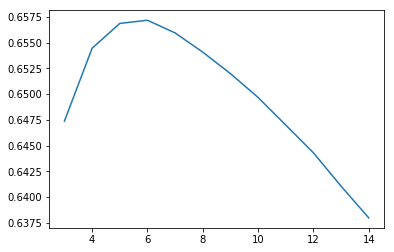

In [318]:
# k = 6 的时候，准确率最高
plt.plot(ks,ss)
# plt.plot(ks,ms)

## 随机森林

In [299]:
# 随机森林
# 导入需要训练和评估api
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
# 模型训练
# n_jobs=-1 表示训练的时候，并行数和cpu的核数一样，如果传入具体的值，表示用几个核去跑
rf1 = RandomForestRegressor(n_estimators=40, 
                           min_samples_leaf=3, 
                           max_features='sqrt',
                           n_jobs=-1)

rf1.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [293]:
# 预测
y_pre = rf1.predict(X_valid)
# 评估
score_rf = rf1.score(X_valid, y_valid)
mae_rf = mean_absolute_error(y_true=y_valid, y_pred=y_pre)
print("使用随机森林 准确率：{:.4f} MAE：{:.4f}".format(score_rf, mae_rf))

使用随机森林 准确率：0.9253 MAE：0.0609


#### 再次使用随机森林，进行模型训练
减少特征值，提高模型训练效率

In [99]:
# 查看特征值在当前模型中的重要程度
m1.feature_importances_

array([2.17623122e-03, 9.75327977e-02, 2.33933593e-02, 2.42161818e-03,
       8.15627008e-04, 2.18725317e-02, 2.23963137e-01, 1.95633986e-03,
       9.09711540e-03, 1.39178514e-02, 1.75158291e-02, 1.01914505e-02,
       6.41894669e-03, 7.61534742e-03, 3.81682869e-03, 6.16299521e-04,
       1.72382611e-02, 3.02887882e-05, 2.63701443e-03, 1.27472371e-04,
       1.57857422e-04, 2.04737592e-01, 5.72592321e-02, 2.40554900e-03,
       6.32467646e-03, 6.82402868e-03, 9.65499929e-03, 7.04634033e-03,
       1.20621545e-02, 3.52016273e-02, 1.79128031e-01, 0.00000000e+00,
       3.38651861e-03, 6.62192806e-05, 6.98921285e-07, 2.08660059e-04,
       4.47482707e-04, 8.19774759e-08, 3.05924204e-06, 6.41096999e-07,
       9.10910912e-05, 6.23998335e-07, 8.73597108e-06, 2.98597993e-06,
       2.82329121e-04, 2.54101824e-04, 8.98126994e-04, 1.03493884e-03,
       9.20382378e-04, 4.11766881e-03, 4.11921824e-03])

In [100]:
imp_df = pd.DataFrame({"cols":df.columns, "imp":m1.feature_importances_})

In [101]:
imp_df.head()

,cols,imp
0,assists,0.002176
1,boosts,0.097533
2,damageDealt,0.023393
3,DBNOs,0.002422
4,headshotKills,0.000816


In [102]:
imp_df = imp_df.sort_values("imp", ascending=False)

In [103]:
imp_df.head()

,cols,imp
6,killPlace,0.223963
21,walkDistance,0.204738
30,totalDistance,0.179128
1,boosts,0.097533
22,weaponsAcquired,0.057259


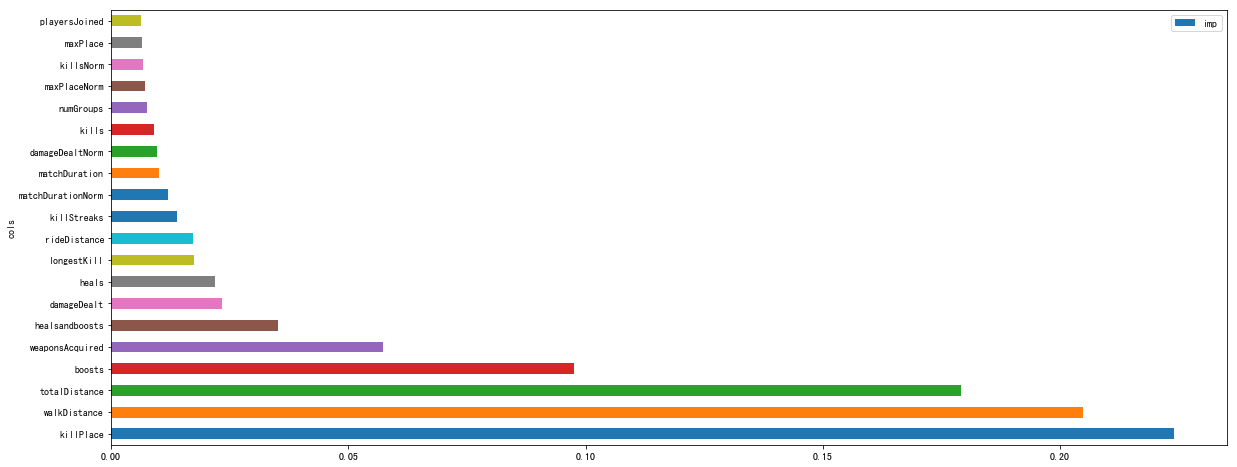

In [105]:
# 绘制特征重要性程度图，仅展示排名前二十的特征
imp_df[:20].plot('cols', 'imp', figsize=(20,8), kind = 'barh')
plt.show()

In [106]:
# 保留比较重要的特征
to_keep = imp_df[imp_df.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  20


6             killPlace
21         walkDistance
30        totalDistance
1                boosts
22      weaponsAcquired
29       healsandboosts
2           damageDealt
5                 heals
10          longestKill
16         rideDistance
9           killStreaks
28    matchDurationNorm
11        matchDuration
26      damageDealtNorm
8                 kills
13            numGroups
27         maxPlaceNorm
25            killsNorm
12             maxPlace
24        playersJoined
Name: cols, dtype: object

In [107]:
# 由这些比较重要的特征值，生成新的df
df[to_keep].head()

,killPlace,walkDistance,totalDistance,boosts,weaponsAcquired,healsandboosts,damageDealt,heals,longestKill,rideDistance,killStreaks,matchDurationNorm,matchDuration,damageDealtNorm,kills,numGroups,maxPlaceNorm,killsNorm,maxPlace,playersJoined
3333517,59,554.9,554.9,0,2,0,0.0,0,0.0,0.0,0,1484.58,1362,0.000,0,26,28.34,0.00,26,91
2340617,69,567.8,567.8,0,3,0,0.0,0,0.0,0.0,0,1303.00,1303,0.000,0,28,29.00,0.00,29,100
2585314,1,2733.0,2733.0,6,5,7,579.2,1,105.0,0.0,3,1419.84,1392,590.784,6,25,28.56,6.12,28,98
1748682,66,401.2,401.2,0,2,0,0.0,0,0.0,0.0,0,1588.26,1542,0.000,0,29,29.87,0.00,29,97
2675858,63,500.7,500.7,0,7,0,100.0,0,0.0,0.0,0,1434.18,1353,106.000,0,26,30.74,0.00,29,94


In [108]:
# 重新制定训练集和测试集
df_keep = df[to_keep]
X_train, X_valid, y_train, y_valid = train_test_split(df_keep, y, test_size=0.2)

In [109]:
X_train.shape

(800000, 20)

In [110]:
# 模型训练
m2 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
# n_jobs=-1 表示训练的时候，并行数和cpu的核数一样，如果传入具体的值，表示用几个核去跑

m2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [111]:
# 模型评分
y_pre = m2.predict(X_valid)
m2.score(X_valid, y_valid)

0.925042188974269

In [112]:
# mae评估
mean_absolute_error(y_true=y_valid, y_pred=y_pre)

# 使用该种方法,最后得到的结果,反而更差,停止优化!

0.059458061434114695

### 使用lightGBM对模型进行训练

#### 模型初次尝试

In [113]:
import lightgbm as lgb

In [114]:
# 创建模型，训练模型
gbm = lgb.LGBMRegressor(objective='regression', 
                        num_leaves=31, 
                        learning_rate=0.05, 
                        n_estimators=20)

gbm.fit(X_train, y_train, 
        eval_set=[(X_valid, y_valid)], 
        eval_metric='l1', 
        early_stopping_rounds=5)
# ps:最后几个参数必须一起使用.


[1]	valid_0's l1: 0.256563	valid_0's l2: 0.0867847
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.245423	valid_0's l2: 0.0796385
[3]	valid_0's l1: 0.234908	valid_0's l2: 0.0731768
[4]	valid_0's l1: 0.224959	valid_0's l2: 0.0673311
[5]	valid_0's l1: 0.215523	valid_0's l2: 0.0620034
[6]	valid_0's l1: 0.206681	valid_0's l2: 0.0572147
[7]	valid_0's l1: 0.198265	valid_0's l2: 0.0528462
[8]	valid_0's l1: 0.190331	valid_0's l2: 0.0489133
[9]	valid_0's l1: 0.182804	valid_0's l2: 0.0453153
[10]	valid_0's l1: 0.175782	valid_0's l2: 0.04209
[11]	valid_0's l1: 0.169071	valid_0's l2: 0.0391245
[12]	valid_0's l1: 0.162789	valid_0's l2: 0.0364604
[13]	valid_0's l1: 0.15683	valid_0's l2: 0.0340198
[14]	valid_0's l1: 0.151185	valid_0's l2: 0.0318046
[15]	valid_0's l1: 0.145968	valid_0's l2: 0.0298251
[16]	valid_0's l1: 0.140993	valid_0's l2: 0.0279967
[17]	valid_0's l1: 0.136255	valid_0's l2: 0.0263162
[18]	valid_0's l1: 0.131884	valid_0's l2: 0.0248212
[19]	valid_0's l

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=20, n_jobs=-1, num_leaves=31, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [115]:
# 测试机预测
y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration_)

In [116]:
mean_absolute_error(y_valid, y_pred)

0.12377160996388074

#### 模型二次调优

In [117]:
from sklearn.model_selection import GridSearchCV
# 网格搜索，参数优化
estimator = lgb.LGBMRegressor(num_leaves=31)
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40, 60, 100, 200, 300]
}
gbm = GridSearchCV(estimator, param_grid, cv=5, n_jobs=-1) # 此处原来有个警告,通过此添加,解决掉!!!
gbm.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [20, 40, 60, 100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=True, ret

In [118]:
# 测试机预测
y_pred = gbm.predict(X_valid)
mean_absolute_error(y_valid, y_pred)

0.0563473409408613

In [119]:
print('交叉验证\网格搜索调试后,最好的参数模型是:', gbm.best_params_)

交叉验证\网格搜索调试后,最好的参数模型是: {'learning_rate': 0.1, 'n_estimators': 300}


#### 模型三次调优[思路]

In [120]:
# n_estimators
scores = []
n_estimators = [100, 500, 1000]

for nes in n_estimators:
    lgbm = lgb.LGBMRegressor(boosting_type='gbdt', 
                      num_leaves=31,
                      max_depth=5,
                      learning_rate=0.1,
                      n_estimators=nes,
                      min_child_samples=20,
                      n_jobs=-1)
    
    lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='l1', early_stopping_rounds=5)
    y_pre = lgbm.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pre)
    scores.append(mae)
    print("test data mae eval : {}".format(mae))

[1]	valid_0's l1: 0.245267	valid_0's l2: 0.0795162
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.224737	valid_0's l2: 0.0671765
[3]	valid_0's l1: 0.20653	valid_0's l2: 0.0571602
[4]	valid_0's l1: 0.190403	valid_0's l2: 0.0489885
[5]	valid_0's l1: 0.175899	valid_0's l2: 0.0422422
[6]	valid_0's l1: 0.163267	valid_0's l2: 0.0367505
[7]	valid_0's l1: 0.151982	valid_0's l2: 0.0322171
[8]	valid_0's l1: 0.142027	valid_0's l2: 0.0285536
[9]	valid_0's l1: 0.132673	valid_0's l2: 0.0252855
[10]	valid_0's l1: 0.125006	valid_0's l2: 0.0228082
[11]	valid_0's l1: 0.117697	valid_0's l2: 0.0205638
[12]	valid_0's l1: 0.111481	valid_0's l2: 0.0188096
[13]	valid_0's l1: 0.106351	valid_0's l2: 0.017436
[14]	valid_0's l1: 0.1013	valid_0's l2: 0.0161026
[15]	valid_0's l1: 0.0967535	valid_0's l2: 0.0149705
[16]	valid_0's l1: 0.0929724	valid_0's l2: 0.0141016
[17]	valid_0's l1: 0.0895386	valid_0's l2: 0.0133302
[18]	valid_0's l1: 0.0865851	valid_0's l2: 0.0127085
[19]	valid_0'

[53]	valid_0's l1: 0.0618657	valid_0's l2: 0.00758933
[54]	valid_0's l1: 0.0617022	valid_0's l2: 0.00754466
[55]	valid_0's l1: 0.0616133	valid_0's l2: 0.00752466
[56]	valid_0's l1: 0.0615318	valid_0's l2: 0.00750508
[57]	valid_0's l1: 0.0614573	valid_0's l2: 0.00748862
[58]	valid_0's l1: 0.0613179	valid_0's l2: 0.00745431
[59]	valid_0's l1: 0.0612027	valid_0's l2: 0.00742199
[60]	valid_0's l1: 0.0611337	valid_0's l2: 0.0074062
[61]	valid_0's l1: 0.0610501	valid_0's l2: 0.00738622
[62]	valid_0's l1: 0.0609491	valid_0's l2: 0.00736079
[63]	valid_0's l1: 0.0608982	valid_0's l2: 0.0073494
[64]	valid_0's l1: 0.0608222	valid_0's l2: 0.00732709
[65]	valid_0's l1: 0.0607399	valid_0's l2: 0.00730179
[66]	valid_0's l1: 0.0606308	valid_0's l2: 0.00727444
[67]	valid_0's l1: 0.0605599	valid_0's l2: 0.00725635
[68]	valid_0's l1: 0.0605103	valid_0's l2: 0.00724319
[69]	valid_0's l1: 0.0604466	valid_0's l2: 0.00722795
[70]	valid_0's l1: 0.0603886	valid_0's l2: 0.00721574
[71]	valid_0's l1: 0.0603501	v

[208]	valid_0's l1: 0.0573335	valid_0's l2: 0.00645639
[209]	valid_0's l1: 0.0573277	valid_0's l2: 0.00645537
[210]	valid_0's l1: 0.0573256	valid_0's l2: 0.00645507
[211]	valid_0's l1: 0.0573163	valid_0's l2: 0.00645337
[212]	valid_0's l1: 0.0573131	valid_0's l2: 0.00645262
[213]	valid_0's l1: 0.0573064	valid_0's l2: 0.00645148
[214]	valid_0's l1: 0.0573042	valid_0's l2: 0.00645085
[215]	valid_0's l1: 0.0572871	valid_0's l2: 0.00644752
[216]	valid_0's l1: 0.0572829	valid_0's l2: 0.0064466
[217]	valid_0's l1: 0.0572743	valid_0's l2: 0.00644461
[218]	valid_0's l1: 0.0572706	valid_0's l2: 0.00644412
[219]	valid_0's l1: 0.0572678	valid_0's l2: 0.00644322
[220]	valid_0's l1: 0.0572528	valid_0's l2: 0.0064393
[221]	valid_0's l1: 0.0572422	valid_0's l2: 0.00643719
[222]	valid_0's l1: 0.0572347	valid_0's l2: 0.00643581
[223]	valid_0's l1: 0.0572263	valid_0's l2: 0.00643393
[224]	valid_0's l1: 0.0572165	valid_0's l2: 0.00643245
[225]	valid_0's l1: 0.0572134	valid_0's l2: 0.00643117
[226]	valid_

[364]	valid_0's l1: 0.0566204	valid_0's l2: 0.00630079
[365]	valid_0's l1: 0.0566172	valid_0's l2: 0.00630019
[366]	valid_0's l1: 0.0566124	valid_0's l2: 0.0062984
[367]	valid_0's l1: 0.0566026	valid_0's l2: 0.00629652
[368]	valid_0's l1: 0.0565985	valid_0's l2: 0.00629574
[369]	valid_0's l1: 0.0565979	valid_0's l2: 0.00629539
[370]	valid_0's l1: 0.0565934	valid_0's l2: 0.0062938
[371]	valid_0's l1: 0.0565899	valid_0's l2: 0.00629314
[372]	valid_0's l1: 0.0565891	valid_0's l2: 0.00629302
[373]	valid_0's l1: 0.0565888	valid_0's l2: 0.0062927
[374]	valid_0's l1: 0.0565879	valid_0's l2: 0.00629234
[375]	valid_0's l1: 0.0565884	valid_0's l2: 0.00629281
[376]	valid_0's l1: 0.0565862	valid_0's l2: 0.00629266
[377]	valid_0's l1: 0.0565857	valid_0's l2: 0.00629245
[378]	valid_0's l1: 0.0565806	valid_0's l2: 0.00629124
[379]	valid_0's l1: 0.0565773	valid_0's l2: 0.00629098
[380]	valid_0's l1: 0.0565761	valid_0's l2: 0.00629082
[381]	valid_0's l1: 0.0565761	valid_0's l2: 0.00629063
[382]	valid_0

[37]	valid_0's l1: 0.0652681	valid_0's l2: 0.00838976
[38]	valid_0's l1: 0.0649006	valid_0's l2: 0.00828716
[39]	valid_0's l1: 0.0644844	valid_0's l2: 0.00817485
[40]	valid_0's l1: 0.0641535	valid_0's l2: 0.00809623
[41]	valid_0's l1: 0.0639052	valid_0's l2: 0.00804303
[42]	valid_0's l1: 0.0636884	valid_0's l2: 0.0080029
[43]	valid_0's l1: 0.0634446	valid_0's l2: 0.0079498
[44]	valid_0's l1: 0.0631861	valid_0's l2: 0.00788263
[45]	valid_0's l1: 0.0630324	valid_0's l2: 0.00785159
[46]	valid_0's l1: 0.0628667	valid_0's l2: 0.00781836
[47]	valid_0's l1: 0.0626865	valid_0's l2: 0.00776301
[48]	valid_0's l1: 0.0625642	valid_0's l2: 0.00774047
[49]	valid_0's l1: 0.0623984	valid_0's l2: 0.0077069
[50]	valid_0's l1: 0.0621945	valid_0's l2: 0.00766005
[51]	valid_0's l1: 0.0620303	valid_0's l2: 0.007622
[52]	valid_0's l1: 0.0619506	valid_0's l2: 0.00760474
[53]	valid_0's l1: 0.0618657	valid_0's l2: 0.00758933
[54]	valid_0's l1: 0.0617022	valid_0's l2: 0.00754466
[55]	valid_0's l1: 0.0616133	vali

[191]	valid_0's l1: 0.0574535	valid_0's l2: 0.00648553
[192]	valid_0's l1: 0.0574523	valid_0's l2: 0.00648468
[193]	valid_0's l1: 0.0574439	valid_0's l2: 0.00648231
[194]	valid_0's l1: 0.0574386	valid_0's l2: 0.00648106
[195]	valid_0's l1: 0.0574236	valid_0's l2: 0.00647759
[196]	valid_0's l1: 0.0574175	valid_0's l2: 0.00647631
[197]	valid_0's l1: 0.0574055	valid_0's l2: 0.00647349
[198]	valid_0's l1: 0.0574022	valid_0's l2: 0.00647307
[199]	valid_0's l1: 0.0573995	valid_0's l2: 0.00647162
[200]	valid_0's l1: 0.0573849	valid_0's l2: 0.00646739
[201]	valid_0's l1: 0.0573772	valid_0's l2: 0.00646651
[202]	valid_0's l1: 0.0573739	valid_0's l2: 0.00646628
[203]	valid_0's l1: 0.0573693	valid_0's l2: 0.00646513
[204]	valid_0's l1: 0.0573635	valid_0's l2: 0.00646349
[205]	valid_0's l1: 0.0573611	valid_0's l2: 0.0064624
[206]	valid_0's l1: 0.0573524	valid_0's l2: 0.00646074
[207]	valid_0's l1: 0.0573445	valid_0's l2: 0.00645949
[208]	valid_0's l1: 0.0573335	valid_0's l2: 0.00645639
[209]	valid

[344]	valid_0's l1: 0.056662	valid_0's l2: 0.00630982
[345]	valid_0's l1: 0.056658	valid_0's l2: 0.00630876
[346]	valid_0's l1: 0.0566579	valid_0's l2: 0.00630881
[347]	valid_0's l1: 0.0566577	valid_0's l2: 0.00630861
[348]	valid_0's l1: 0.0566561	valid_0's l2: 0.00630818
[349]	valid_0's l1: 0.0566534	valid_0's l2: 0.00630773
[350]	valid_0's l1: 0.0566486	valid_0's l2: 0.00630674
[351]	valid_0's l1: 0.0566477	valid_0's l2: 0.00630682
[352]	valid_0's l1: 0.0566454	valid_0's l2: 0.0063065
[353]	valid_0's l1: 0.0566426	valid_0's l2: 0.0063059
[354]	valid_0's l1: 0.0566419	valid_0's l2: 0.00630586
[355]	valid_0's l1: 0.0566393	valid_0's l2: 0.00630526
[356]	valid_0's l1: 0.0566375	valid_0's l2: 0.00630493
[357]	valid_0's l1: 0.0566355	valid_0's l2: 0.00630456
[358]	valid_0's l1: 0.056635	valid_0's l2: 0.00630451
[359]	valid_0's l1: 0.0566338	valid_0's l2: 0.0063042
[360]	valid_0's l1: 0.056626	valid_0's l2: 0.0063024
[361]	valid_0's l1: 0.0566251	valid_0's l2: 0.00630217
[362]	valid_0's l1

best n_estimator 500


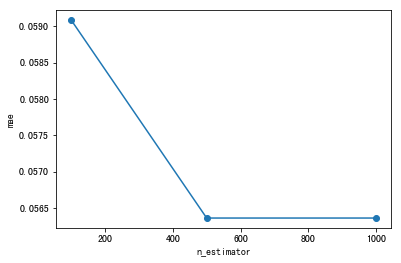

In [121]:
plt.plot(n_estimators,scores,'o-')
plt.ylabel("mae")
plt.xlabel("n_estimator")
print("best n_estimator {}".format(n_estimators[np.argmin(scores)]))

In [122]:
# max_depths
scores = []
max_depths = [1, 5, 7, 9]

for nes in max_depths:
    lgbm = lgb.LGBMRegressor(boosting_type='gbdt', 
                      num_leaves=31,
                      max_depth=nes,
                      learning_rate=0.1,
                      n_estimators=1000,
                      min_child_samples=20,
                      n_jobs=-1)
    lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='l1', early_stopping_rounds=5)
    y_pre = lgbm.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pre)
    scores.append(mae)
    print("test data mae eval : {}".format(mae))

[1]	valid_0's l1: 0.250578	valid_0's l2: 0.0837611
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.235479	valid_0's l2: 0.0748281
[3]	valid_0's l1: 0.222375	valid_0's l2: 0.0674274
[4]	valid_0's l1: 0.211114	valid_0's l2: 0.0612424
[5]	valid_0's l1: 0.201183	valid_0's l2: 0.05605
[6]	valid_0's l1: 0.192149	valid_0's l2: 0.0515894
[7]	valid_0's l1: 0.184036	valid_0's l2: 0.0476157
[8]	valid_0's l1: 0.176816	valid_0's l2: 0.0443099
[9]	valid_0's l1: 0.170259	valid_0's l2: 0.0413318
[10]	valid_0's l1: 0.164464	valid_0's l2: 0.0387888
[11]	valid_0's l1: 0.15926	valid_0's l2: 0.0365382
[12]	valid_0's l1: 0.154226	valid_0's l2: 0.0345344
[13]	valid_0's l1: 0.149733	valid_0's l2: 0.0328349
[14]	valid_0's l1: 0.145837	valid_0's l2: 0.0312783
[15]	valid_0's l1: 0.142283	valid_0's l2: 0.0299292
[16]	valid_0's l1: 0.139158	valid_0's l2: 0.0287414
[17]	valid_0's l1: 0.135828	valid_0's l2: 0.0276431
[18]	valid_0's l1: 0.133072	valid_0's l2: 0.0266594
[19]	valid_0's l

[160]	valid_0's l1: 0.0880945	valid_0's l2: 0.0146907
[161]	valid_0's l1: 0.0880901	valid_0's l2: 0.0146787
[162]	valid_0's l1: 0.0880334	valid_0's l2: 0.0146674
[163]	valid_0's l1: 0.0879772	valid_0's l2: 0.0146558
[164]	valid_0's l1: 0.0879731	valid_0's l2: 0.0146443
[165]	valid_0's l1: 0.0879037	valid_0's l2: 0.0146326
[166]	valid_0's l1: 0.0878793	valid_0's l2: 0.0146209
[167]	valid_0's l1: 0.0878176	valid_0's l2: 0.0146102
[168]	valid_0's l1: 0.0878128	valid_0's l2: 0.0145986
[169]	valid_0's l1: 0.0877589	valid_0's l2: 0.0145877
[170]	valid_0's l1: 0.0877549	valid_0's l2: 0.0145766
[171]	valid_0's l1: 0.0876892	valid_0's l2: 0.0145655
[172]	valid_0's l1: 0.0876493	valid_0's l2: 0.0145555
[173]	valid_0's l1: 0.0876	valid_0's l2: 0.0145451
[174]	valid_0's l1: 0.0875964	valid_0's l2: 0.0145344
[175]	valid_0's l1: 0.0875447	valid_0's l2: 0.0145239
[176]	valid_0's l1: 0.087521	valid_0's l2: 0.0145127
[177]	valid_0's l1: 0.0875177	valid_0's l2: 0.0145023
[178]	valid_0's l1: 0.0874536	va

[321]	valid_0's l1: 0.0841735	valid_0's l2: 0.0135137
[322]	valid_0's l1: 0.0841679	valid_0's l2: 0.013509
[323]	valid_0's l1: 0.084148	valid_0's l2: 0.0135042
[324]	valid_0's l1: 0.0841471	valid_0's l2: 0.013499
[325]	valid_0's l1: 0.0841133	valid_0's l2: 0.013494
[326]	valid_0's l1: 0.0840976	valid_0's l2: 0.0134882
[327]	valid_0's l1: 0.0840973	valid_0's l2: 0.0134833
[328]	valid_0's l1: 0.0840639	valid_0's l2: 0.0134783
[329]	valid_0's l1: 0.0840694	valid_0's l2: 0.0134738
[330]	valid_0's l1: 0.0840499	valid_0's l2: 0.0134692
[331]	valid_0's l1: 0.084049	valid_0's l2: 0.0134639
[332]	valid_0's l1: 0.0840254	valid_0's l2: 0.0134594
[333]	valid_0's l1: 0.0840248	valid_0's l2: 0.0134544
[334]	valid_0's l1: 0.0839922	valid_0's l2: 0.0134495
[335]	valid_0's l1: 0.0839919	valid_0's l2: 0.0134447
[336]	valid_0's l1: 0.0839738	valid_0's l2: 0.0134402
[337]	valid_0's l1: 0.0839603	valid_0's l2: 0.0134349
[338]	valid_0's l1: 0.0839367	valid_0's l2: 0.0134304
[339]	valid_0's l1: 0.0839404	val

[475]	valid_0's l1: 0.0821496	valid_0's l2: 0.012867
[476]	valid_0's l1: 0.0821297	valid_0's l2: 0.0128636
[477]	valid_0's l1: 0.0821336	valid_0's l2: 0.0128601
[478]	valid_0's l1: 0.0821006	valid_0's l2: 0.0128564
[479]	valid_0's l1: 0.0820793	valid_0's l2: 0.0128527
[480]	valid_0's l1: 0.0820805	valid_0's l2: 0.0128491
[481]	valid_0's l1: 0.0820538	valid_0's l2: 0.0128456
[482]	valid_0's l1: 0.0820551	valid_0's l2: 0.012842
[483]	valid_0's l1: 0.0820399	valid_0's l2: 0.0128386
[484]	valid_0's l1: 0.0820448	valid_0's l2: 0.0128353
[485]	valid_0's l1: 0.0820191	valid_0's l2: 0.0128319
[486]	valid_0's l1: 0.0820212	valid_0's l2: 0.0128282
[487]	valid_0's l1: 0.0819951	valid_0's l2: 0.0128247
[488]	valid_0's l1: 0.0819843	valid_0's l2: 0.0128208
[489]	valid_0's l1: 0.0819867	valid_0's l2: 0.0128173
[490]	valid_0's l1: 0.0819608	valid_0's l2: 0.0128139
[491]	valid_0's l1: 0.0819621	valid_0's l2: 0.0128103
[492]	valid_0's l1: 0.0819359	valid_0's l2: 0.0128069
[493]	valid_0's l1: 0.0819383	

[631]	valid_0's l1: 0.0805786	valid_0's l2: 0.012371
[632]	valid_0's l1: 0.0805813	valid_0's l2: 0.0123682
[633]	valid_0's l1: 0.0805595	valid_0's l2: 0.0123654
[634]	valid_0's l1: 0.080563	valid_0's l2: 0.0123628
[635]	valid_0's l1: 0.0805468	valid_0's l2: 0.0123602
[636]	valid_0's l1: 0.0805481	valid_0's l2: 0.0123571
[637]	valid_0's l1: 0.0805265	valid_0's l2: 0.0123543
[638]	valid_0's l1: 0.080528	valid_0's l2: 0.0123513
[639]	valid_0's l1: 0.0805116	valid_0's l2: 0.0123487
[640]	valid_0's l1: 0.0805097	valid_0's l2: 0.0123459
[641]	valid_0's l1: 0.0804984	valid_0's l2: 0.0123432
[642]	valid_0's l1: 0.0804899	valid_0's l2: 0.0123404
[643]	valid_0's l1: 0.0804918	valid_0's l2: 0.0123376
[644]	valid_0's l1: 0.0804695	valid_0's l2: 0.0123349
[645]	valid_0's l1: 0.0804714	valid_0's l2: 0.0123322
[646]	valid_0's l1: 0.0804494	valid_0's l2: 0.0123295
[647]	valid_0's l1: 0.0804522	valid_0's l2: 0.0123269
[648]	valid_0's l1: 0.0804306	valid_0's l2: 0.0123242
[649]	valid_0's l1: 0.0804351	v

[792]	valid_0's l1: 0.0793127	valid_0's l2: 0.0119687
[793]	valid_0's l1: 0.0793119	valid_0's l2: 0.0119665
[794]	valid_0's l1: 0.0792975	valid_0's l2: 0.0119639
[795]	valid_0's l1: 0.0792838	valid_0's l2: 0.0119616
[796]	valid_0's l1: 0.0792867	valid_0's l2: 0.0119597
[797]	valid_0's l1: 0.0792695	valid_0's l2: 0.0119574
[798]	valid_0's l1: 0.0792715	valid_0's l2: 0.0119551
[799]	valid_0's l1: 0.0792522	valid_0's l2: 0.0119527
[800]	valid_0's l1: 0.0792433	valid_0's l2: 0.0119499
[801]	valid_0's l1: 0.0792455	valid_0's l2: 0.0119476
[802]	valid_0's l1: 0.0792268	valid_0's l2: 0.0119455
[803]	valid_0's l1: 0.0792298	valid_0's l2: 0.0119434
[804]	valid_0's l1: 0.0792118	valid_0's l2: 0.0119412
[805]	valid_0's l1: 0.079218	valid_0's l2: 0.0119392
[806]	valid_0's l1: 0.0792075	valid_0's l2: 0.0119372
[807]	valid_0's l1: 0.0792093	valid_0's l2: 0.0119347
[808]	valid_0's l1: 0.0791913	valid_0's l2: 0.0119326
[809]	valid_0's l1: 0.0791942	valid_0's l2: 0.0119303
[810]	valid_0's l1: 0.0791766

[951]	valid_0's l1: 0.0782712	valid_0's l2: 0.0116463
[952]	valid_0's l1: 0.0782734	valid_0's l2: 0.0116445
[953]	valid_0's l1: 0.0782575	valid_0's l2: 0.0116428
[954]	valid_0's l1: 0.0782599	valid_0's l2: 0.0116409
[955]	valid_0's l1: 0.0782468	valid_0's l2: 0.0116393
[956]	valid_0's l1: 0.0782493	valid_0's l2: 0.0116377
[957]	valid_0's l1: 0.0782398	valid_0's l2: 0.0116353
[958]	valid_0's l1: 0.0782254	valid_0's l2: 0.0116337
[959]	valid_0's l1: 0.0782285	valid_0's l2: 0.0116318
[960]	valid_0's l1: 0.0782139	valid_0's l2: 0.0116299
[961]	valid_0's l1: 0.0782163	valid_0's l2: 0.011628
[962]	valid_0's l1: 0.0782006	valid_0's l2: 0.0116263
[963]	valid_0's l1: 0.0782038	valid_0's l2: 0.0116244
[964]	valid_0's l1: 0.0781892	valid_0's l2: 0.0116228
[965]	valid_0's l1: 0.0781924	valid_0's l2: 0.011621
[966]	valid_0's l1: 0.0781759	valid_0's l2: 0.0116192
[967]	valid_0's l1: 0.0781825	valid_0's l2: 0.0116176
[968]	valid_0's l1: 0.0781741	valid_0's l2: 0.0116159
[969]	valid_0's l1: 0.0781765	

[106]	valid_0's l1: 0.0589043	valid_0's l2: 0.00683727
[107]	valid_0's l1: 0.0588527	valid_0's l2: 0.00682399
[108]	valid_0's l1: 0.0588104	valid_0's l2: 0.00681042
[109]	valid_0's l1: 0.0587857	valid_0's l2: 0.00680483
[110]	valid_0's l1: 0.0587581	valid_0's l2: 0.00679719
[111]	valid_0's l1: 0.0587335	valid_0's l2: 0.00679066
[112]	valid_0's l1: 0.058712	valid_0's l2: 0.00678597
[113]	valid_0's l1: 0.0587039	valid_0's l2: 0.0067833
[114]	valid_0's l1: 0.0586656	valid_0's l2: 0.00677397
[115]	valid_0's l1: 0.0586325	valid_0's l2: 0.00676673
[116]	valid_0's l1: 0.0586215	valid_0's l2: 0.00676278
[117]	valid_0's l1: 0.0585969	valid_0's l2: 0.00675665
[118]	valid_0's l1: 0.0585855	valid_0's l2: 0.00675394
[119]	valid_0's l1: 0.0585303	valid_0's l2: 0.00673981
[120]	valid_0's l1: 0.0585118	valid_0's l2: 0.00673499
[121]	valid_0's l1: 0.0584861	valid_0's l2: 0.00672953
[122]	valid_0's l1: 0.0584369	valid_0's l2: 0.0067154
[123]	valid_0's l1: 0.058406	valid_0's l2: 0.00670954
[124]	valid_0'

[263]	valid_0's l1: 0.0569727	valid_0's l2: 0.0063754
[264]	valid_0's l1: 0.0569716	valid_0's l2: 0.00637516
[265]	valid_0's l1: 0.0569695	valid_0's l2: 0.00637479
[266]	valid_0's l1: 0.0569644	valid_0's l2: 0.00637328
[267]	valid_0's l1: 0.0569613	valid_0's l2: 0.00637212
[268]	valid_0's l1: 0.0569608	valid_0's l2: 0.0063722
[269]	valid_0's l1: 0.0569593	valid_0's l2: 0.00637186
[270]	valid_0's l1: 0.0569547	valid_0's l2: 0.00637182
[271]	valid_0's l1: 0.0569521	valid_0's l2: 0.00637158
[272]	valid_0's l1: 0.0569519	valid_0's l2: 0.00637123
[273]	valid_0's l1: 0.0569525	valid_0's l2: 0.00637126
[274]	valid_0's l1: 0.0569434	valid_0's l2: 0.00637082
[275]	valid_0's l1: 0.0569353	valid_0's l2: 0.00636853
[276]	valid_0's l1: 0.0569302	valid_0's l2: 0.00636774
[277]	valid_0's l1: 0.0569228	valid_0's l2: 0.00636642
[278]	valid_0's l1: 0.0569137	valid_0's l2: 0.00636372
[279]	valid_0's l1: 0.0569065	valid_0's l2: 0.00636186
[280]	valid_0's l1: 0.056902	valid_0's l2: 0.00636129
[281]	valid_0

[413]	valid_0's l1: 0.0564935	valid_0's l2: 0.00627464
[414]	valid_0's l1: 0.0564926	valid_0's l2: 0.00627455
[415]	valid_0's l1: 0.0564874	valid_0's l2: 0.00627345
[416]	valid_0's l1: 0.0564837	valid_0's l2: 0.00627292
[417]	valid_0's l1: 0.0564819	valid_0's l2: 0.0062725
[418]	valid_0's l1: 0.0564801	valid_0's l2: 0.00627223
[419]	valid_0's l1: 0.0564794	valid_0's l2: 0.00627207
[420]	valid_0's l1: 0.056479	valid_0's l2: 0.00627171
[421]	valid_0's l1: 0.0564783	valid_0's l2: 0.00627145
[422]	valid_0's l1: 0.0564754	valid_0's l2: 0.00627119
[423]	valid_0's l1: 0.0564724	valid_0's l2: 0.00627067
[424]	valid_0's l1: 0.0564689	valid_0's l2: 0.00626976
[425]	valid_0's l1: 0.0564669	valid_0's l2: 0.00626916
[426]	valid_0's l1: 0.0564628	valid_0's l2: 0.00626837
[427]	valid_0's l1: 0.0564625	valid_0's l2: 0.00626831
[428]	valid_0's l1: 0.0564567	valid_0's l2: 0.00626711
[429]	valid_0's l1: 0.0564563	valid_0's l2: 0.00626702
[430]	valid_0's l1: 0.0564521	valid_0's l2: 0.00626645
[431]	valid_

[84]	valid_0's l1: 0.0587144	valid_0's l2: 0.00675803
[85]	valid_0's l1: 0.0586588	valid_0's l2: 0.00674577
[86]	valid_0's l1: 0.0586284	valid_0's l2: 0.00674036
[87]	valid_0's l1: 0.0586	valid_0's l2: 0.00673542
[88]	valid_0's l1: 0.0585801	valid_0's l2: 0.00673014
[89]	valid_0's l1: 0.0585305	valid_0's l2: 0.0067182
[90]	valid_0's l1: 0.0585066	valid_0's l2: 0.00671249
[91]	valid_0's l1: 0.058483	valid_0's l2: 0.00670526
[92]	valid_0's l1: 0.058459	valid_0's l2: 0.0066972
[93]	valid_0's l1: 0.0584456	valid_0's l2: 0.00669266
[94]	valid_0's l1: 0.0584189	valid_0's l2: 0.0066867
[95]	valid_0's l1: 0.0583758	valid_0's l2: 0.006675
[96]	valid_0's l1: 0.0583566	valid_0's l2: 0.00666943
[97]	valid_0's l1: 0.0583291	valid_0's l2: 0.00666324
[98]	valid_0's l1: 0.0583098	valid_0's l2: 0.00665874
[99]	valid_0's l1: 0.058278	valid_0's l2: 0.00665317
[100]	valid_0's l1: 0.0582664	valid_0's l2: 0.00665109
[101]	valid_0's l1: 0.058222	valid_0's l2: 0.00664031
[102]	valid_0's l1: 0.0581836	valid_0'

[235]	valid_0's l1: 0.0567026	valid_0's l2: 0.00631627
[236]	valid_0's l1: 0.0567004	valid_0's l2: 0.0063159
[237]	valid_0's l1: 0.0566919	valid_0's l2: 0.00631415
[238]	valid_0's l1: 0.0566877	valid_0's l2: 0.00631364
[239]	valid_0's l1: 0.0566867	valid_0's l2: 0.00631322
[240]	valid_0's l1: 0.0566849	valid_0's l2: 0.00631275
[241]	valid_0's l1: 0.0566832	valid_0's l2: 0.0063125
[242]	valid_0's l1: 0.0566755	valid_0's l2: 0.00631106
[243]	valid_0's l1: 0.0566697	valid_0's l2: 0.00630967
[244]	valid_0's l1: 0.0566688	valid_0's l2: 0.00630933
[245]	valid_0's l1: 0.0566664	valid_0's l2: 0.00630911
[246]	valid_0's l1: 0.0566636	valid_0's l2: 0.00630882
[247]	valid_0's l1: 0.0566615	valid_0's l2: 0.00630861
[248]	valid_0's l1: 0.0566589	valid_0's l2: 0.00630762
[249]	valid_0's l1: 0.0566572	valid_0's l2: 0.00630703
[250]	valid_0's l1: 0.056654	valid_0's l2: 0.00630639
[251]	valid_0's l1: 0.0566514	valid_0's l2: 0.00630592
[252]	valid_0's l1: 0.0566502	valid_0's l2: 0.00630577
[253]	valid_0

[387]	valid_0's l1: 0.0562385	valid_0's l2: 0.00622699
[388]	valid_0's l1: 0.0562376	valid_0's l2: 0.0062267
[389]	valid_0's l1: 0.0562351	valid_0's l2: 0.00622612
[390]	valid_0's l1: 0.0562353	valid_0's l2: 0.00622617
[391]	valid_0's l1: 0.056235	valid_0's l2: 0.00622621
[392]	valid_0's l1: 0.0562326	valid_0's l2: 0.00622592
[393]	valid_0's l1: 0.0562329	valid_0's l2: 0.006226
[394]	valid_0's l1: 0.0562322	valid_0's l2: 0.00622571
[395]	valid_0's l1: 0.0562312	valid_0's l2: 0.00622572
[396]	valid_0's l1: 0.0562255	valid_0's l2: 0.00622496
[397]	valid_0's l1: 0.0562249	valid_0's l2: 0.00622479
[398]	valid_0's l1: 0.0562202	valid_0's l2: 0.00622437
[399]	valid_0's l1: 0.0562146	valid_0's l2: 0.00622369
[400]	valid_0's l1: 0.056211	valid_0's l2: 0.00622254
[401]	valid_0's l1: 0.0562004	valid_0's l2: 0.00622122
[402]	valid_0's l1: 0.0561976	valid_0's l2: 0.00622042
[403]	valid_0's l1: 0.0561959	valid_0's l2: 0.00622014
[404]	valid_0's l1: 0.0561935	valid_0's l2: 0.00621952
[405]	valid_0's

[537]	valid_0's l1: 0.0559703	valid_0's l2: 0.00618119
[538]	valid_0's l1: 0.0559696	valid_0's l2: 0.00618118
[539]	valid_0's l1: 0.0559691	valid_0's l2: 0.00618102
[540]	valid_0's l1: 0.0559676	valid_0's l2: 0.00618079
[541]	valid_0's l1: 0.0559666	valid_0's l2: 0.00618054
[542]	valid_0's l1: 0.0559662	valid_0's l2: 0.00618054
[543]	valid_0's l1: 0.0559659	valid_0's l2: 0.00618037
[544]	valid_0's l1: 0.0559659	valid_0's l2: 0.00618035
[545]	valid_0's l1: 0.0559586	valid_0's l2: 0.00617941
[546]	valid_0's l1: 0.0559535	valid_0's l2: 0.0061784
[547]	valid_0's l1: 0.0559513	valid_0's l2: 0.00617811
[548]	valid_0's l1: 0.0559476	valid_0's l2: 0.00617752
[549]	valid_0's l1: 0.055947	valid_0's l2: 0.00617749
[550]	valid_0's l1: 0.0559464	valid_0's l2: 0.00617733
[551]	valid_0's l1: 0.0559436	valid_0's l2: 0.00617669
[552]	valid_0's l1: 0.0559435	valid_0's l2: 0.00617659
[553]	valid_0's l1: 0.0559421	valid_0's l2: 0.00617636
[554]	valid_0's l1: 0.0559418	valid_0's l2: 0.0061762
[555]	valid_0

[694]	valid_0's l1: 0.0557952	valid_0's l2: 0.0061512
[695]	valid_0's l1: 0.0557948	valid_0's l2: 0.00615121
[696]	valid_0's l1: 0.0557926	valid_0's l2: 0.00615096
[697]	valid_0's l1: 0.0557902	valid_0's l2: 0.00615055
[698]	valid_0's l1: 0.0557882	valid_0's l2: 0.00615022
[699]	valid_0's l1: 0.0557888	valid_0's l2: 0.00615027
[700]	valid_0's l1: 0.0557891	valid_0's l2: 0.00615037
[701]	valid_0's l1: 0.0557881	valid_0's l2: 0.00615016
[702]	valid_0's l1: 0.0557873	valid_0's l2: 0.0061501
[703]	valid_0's l1: 0.0557875	valid_0's l2: 0.00615005
[704]	valid_0's l1: 0.0557816	valid_0's l2: 0.006149
[705]	valid_0's l1: 0.0557821	valid_0's l2: 0.00614935
[706]	valid_0's l1: 0.0557814	valid_0's l2: 0.00614921
[707]	valid_0's l1: 0.0557803	valid_0's l2: 0.00614896
[708]	valid_0's l1: 0.0557786	valid_0's l2: 0.0061487
[709]	valid_0's l1: 0.0557762	valid_0's l2: 0.00614826
[710]	valid_0's l1: 0.0557743	valid_0's l2: 0.00614801
[711]	valid_0's l1: 0.0557742	valid_0's l2: 0.00614794
[712]	valid_0's

[112]	valid_0's l1: 0.0577083	valid_0's l2: 0.0065148
[113]	valid_0's l1: 0.0576858	valid_0's l2: 0.00651066
[114]	valid_0's l1: 0.057677	valid_0's l2: 0.0065078
[115]	valid_0's l1: 0.0576458	valid_0's l2: 0.00650098
[116]	valid_0's l1: 0.0576321	valid_0's l2: 0.00649904
[117]	valid_0's l1: 0.0576143	valid_0's l2: 0.00649511
[118]	valid_0's l1: 0.057597	valid_0's l2: 0.00649222
[119]	valid_0's l1: 0.0575697	valid_0's l2: 0.00648641
[120]	valid_0's l1: 0.0575486	valid_0's l2: 0.00648085
[121]	valid_0's l1: 0.0575239	valid_0's l2: 0.00647695
[122]	valid_0's l1: 0.0575129	valid_0's l2: 0.00647423
[123]	valid_0's l1: 0.0574971	valid_0's l2: 0.00647048
[124]	valid_0's l1: 0.0574723	valid_0's l2: 0.00646534
[125]	valid_0's l1: 0.0574552	valid_0's l2: 0.00646211
[126]	valid_0's l1: 0.0574391	valid_0's l2: 0.0064578
[127]	valid_0's l1: 0.0574282	valid_0's l2: 0.00645449
[128]	valid_0's l1: 0.0574142	valid_0's l2: 0.00645129
[129]	valid_0's l1: 0.0573971	valid_0's l2: 0.00644723
[130]	valid_0's

[264]	valid_0's l1: 0.0564709	valid_0's l2: 0.00626231
[265]	valid_0's l1: 0.0564698	valid_0's l2: 0.00626192
[266]	valid_0's l1: 0.0564653	valid_0's l2: 0.00626144
[267]	valid_0's l1: 0.0564585	valid_0's l2: 0.00626009
[268]	valid_0's l1: 0.0564572	valid_0's l2: 0.00625944
[269]	valid_0's l1: 0.0564545	valid_0's l2: 0.00625875
[270]	valid_0's l1: 0.0564519	valid_0's l2: 0.00625869
[271]	valid_0's l1: 0.0564491	valid_0's l2: 0.00625836
[272]	valid_0's l1: 0.0564468	valid_0's l2: 0.00625772
[273]	valid_0's l1: 0.056444	valid_0's l2: 0.00625704
[274]	valid_0's l1: 0.0564349	valid_0's l2: 0.00625536
[275]	valid_0's l1: 0.0564285	valid_0's l2: 0.0062542
[276]	valid_0's l1: 0.0564198	valid_0's l2: 0.00625253
[277]	valid_0's l1: 0.0564138	valid_0's l2: 0.00625117
[278]	valid_0's l1: 0.056411	valid_0's l2: 0.00625058
[279]	valid_0's l1: 0.0564094	valid_0's l2: 0.00625019
[280]	valid_0's l1: 0.0564098	valid_0's l2: 0.00625019
[281]	valid_0's l1: 0.0564092	valid_0's l2: 0.00624991
[282]	valid_0

[415]	valid_0's l1: 0.0561019	valid_0's l2: 0.00619582
[416]	valid_0's l1: 0.0561001	valid_0's l2: 0.00619556
[417]	valid_0's l1: 0.0560999	valid_0's l2: 0.00619548
[418]	valid_0's l1: 0.0560983	valid_0's l2: 0.00619538
[419]	valid_0's l1: 0.056097	valid_0's l2: 0.00619514
[420]	valid_0's l1: 0.0560964	valid_0's l2: 0.00619503
[421]	valid_0's l1: 0.0560954	valid_0's l2: 0.00619483
[422]	valid_0's l1: 0.056095	valid_0's l2: 0.00619468
[423]	valid_0's l1: 0.0560951	valid_0's l2: 0.00619477
[424]	valid_0's l1: 0.056091	valid_0's l2: 0.00619394
[425]	valid_0's l1: 0.0560913	valid_0's l2: 0.00619429
[426]	valid_0's l1: 0.0560888	valid_0's l2: 0.00619382
[427]	valid_0's l1: 0.0560843	valid_0's l2: 0.00619321
[428]	valid_0's l1: 0.0560829	valid_0's l2: 0.0061929
[429]	valid_0's l1: 0.0560821	valid_0's l2: 0.00619281
[430]	valid_0's l1: 0.0560802	valid_0's l2: 0.00619266
[431]	valid_0's l1: 0.0560785	valid_0's l2: 0.00619216
[432]	valid_0's l1: 0.0560766	valid_0's l2: 0.00619188
[433]	valid_0'

[566]	valid_0's l1: 0.0558603	valid_0's l2: 0.0061556
[567]	valid_0's l1: 0.0558592	valid_0's l2: 0.00615554
[568]	valid_0's l1: 0.0558583	valid_0's l2: 0.00615541
[569]	valid_0's l1: 0.0558506	valid_0's l2: 0.00615459
[570]	valid_0's l1: 0.0558511	valid_0's l2: 0.00615531
[571]	valid_0's l1: 0.0558515	valid_0's l2: 0.00615507
[572]	valid_0's l1: 0.055851	valid_0's l2: 0.00615502
[573]	valid_0's l1: 0.0558504	valid_0's l2: 0.006155
[574]	valid_0's l1: 0.0558491	valid_0's l2: 0.00615464
Early stopping, best iteration is:
[569]	valid_0's l1: 0.0558506	valid_0's l2: 0.00615459
test data mae eval : 0.0558506474358184


In [125]:
scores

[0.0779863518866087,
 0.05635981971669632,
 0.05575917797092566,
 0.0558506474358184]

best max_depths 7


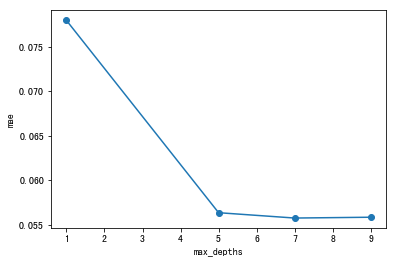

In [124]:
plt.plot(max_depths,scores,'o-')
plt.ylabel("mae")
plt.xlabel("max_depths")
print("best max_depths {}".format(max_depths[np.argmin(scores)]))